In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
# STEP 2: Unzip the archive to /content/celeba_dataset
import zipfile
import os

zip_path = '/content/drive/MyDrive/CelebA/archive (1).zip'
extract_dir = '/content/celeba_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Dataset extracted.")


Dataset extracted.


In [41]:
# STEP 3: Move images to correct folder if nested
import shutil

nested_dir = os.path.join(extract_dir, 'img_align_celeba', 'img_align_celeba')
main_dir = os.path.join(extract_dir, 'img_align_celeba')

if os.path.exists(nested_dir):
    for file in os.listdir(nested_dir):
        shutil.move(os.path.join(nested_dir, file), main_dir)
    os.rmdir(nested_dir)
    print("Fixed nested folder.")

# Confirm images
print("Sample images:", os.listdir(main_dir)[:5])
print("Total images found:", len(os.listdir(main_dir)))


Fixed nested folder.
Sample images: ['038080.jpg', '191269.jpg', '165965.jpg', '174535.jpg', '188978.jpg']
Total images found: 202599


In [42]:
# STEP 4: Load attributes CSV and filter only existing images
import pandas as pd

attr_path = os.path.join(extract_dir, 'list_attr_celeba.csv')
df = pd.read_csv(attr_path)

# Filter only available images
available_imgs = set(os.listdir(main_dir))
df = df[df['image_id'].isin(available_imgs)]

print("Filtered images found:", len(df))


Filtered images found: 202599


In [43]:
# STEP 5: Take 1000 samples
df = df.sample(n=1000, random_state=42).reset_index(drop=True)
df['Eyeglasses'] = df['Eyeglasses'].apply(lambda x: 1 if x == 1 else 0)  # convert -1/1 to 0/1

In [44]:
# STEP 6: Create TensorFlow Dataset
import tensorflow as tf
from PIL import Image
import numpy as np

def load_image(image_id, label):
    path = os.path.join(main_dir, image_id.numpy().decode('utf-8'))
    img = Image.open(path).resize((128, 128)).convert('RGB')
    return np.array(img) / 255.0, label

def tf_wrapper(image_id, label):
    img, lbl = tf.py_function(load_image, [image_id, label], [tf.float32, tf.int64])
    img.set_shape([128, 128, 3])
    lbl.set_shape([])
    return img, lbl

image_ids = df['image_id'].values
labels = df['Eyeglasses'].values

dataset = tf.data.Dataset.from_tensor_slices((image_ids, labels))
dataset = dataset.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Train/test split
train_size = int(0.8 * len(df))
train_data = dataset.take(train_size)
test_data = dataset.skip(train_size)


In [45]:
# STEP 7: Define CNN model
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,699,009 (6.48 MB)

 Trainable params: 1,699,009 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# STEP 8: Train the model
model.fit(train_data, validation_data=test_data, epochs=5)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8875 - loss: 0.3394
Epoch 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9416 - loss: 0.2297
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9441 - loss: 0.2099
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9410 - loss: 0.1906
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9613 - loss: 0.1187


In [47]:
# Load sampled data again
sample_df = df.copy()  # Already filtered to 1000

# Map gender: Male = 1, Female = 0
sample_df['Male'] = sample_df['Male'].apply(lambda x: 1 if x == 1 else 0)

# Reload images as numpy arrays for prediction
def load_image_np(image_id):
    path = os.path.join(main_dir, image_id)
    img = Image.open(path).resize((128, 128)).convert('RGB')
    return np.array(img) / 255.0

X = np.stack([load_image_np(img_id) for img_id in sample_df['image_id']])
y_true = sample_df['Eyeglasses'].values
gender = sample_df['Male'].values

# Predict using the model
y_pred_probs = model.predict(X)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 249ms/step


In [48]:
from sklearn.metrics import accuracy_score

# Separate groups
male_mask = gender == 1
female_mask = gender == 0

male_acc = accuracy_score(y_true[male_mask], y_pred[male_mask])
female_acc = accuracy_score(y_true[female_mask], y_pred[female_mask])

print(f"Male Accuracy:   {male_acc * 100:.2f}%")
print(f"Female Accuracy: {female_acc * 100:.2f}%")


Male Accuracy:   92.99%
Female Accuracy: 99.13%


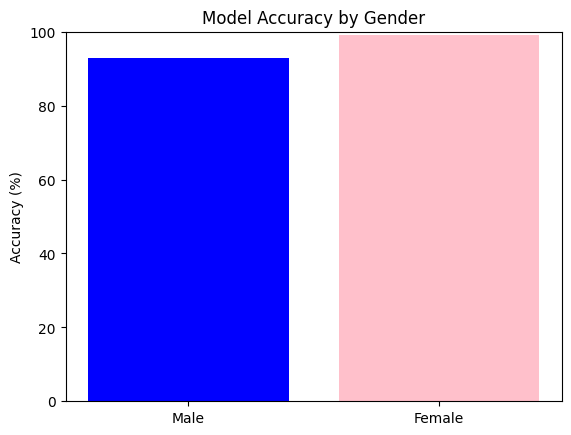

In [49]:
import matplotlib.pyplot as plt

plt.bar(['Male', 'Female'], [male_acc * 100, female_acc * 100], color=['blue', 'pink'])
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy by Gender")
plt.ylim(0, 100)
plt.show()

In [50]:
def estimate_skin_tone(image_array):
    # Convert RGB to grayscale using luminance formula
    gray = np.dot(image_array[..., :3], [0.2989, 0.5870, 0.1140])
    return np.mean(gray)

# Add estimated skin tone brightness
skin_tone_scores = [estimate_skin_tone(img) for img in X]
sample_df['SkinTone'] = skin_tone_scores

# Decide threshold based on median brightness
threshold = sample_df['SkinTone'].median()
sample_df['SkinToneLabel'] = sample_df['SkinTone'].apply(lambda x: 'Light' if x >= threshold else 'Dark')


In [51]:
light_mask = sample_df['SkinToneLabel'] == 'Light'
dark_mask = sample_df['SkinToneLabel'] == 'Dark'

light_acc = accuracy_score(y_true[light_mask], y_pred[light_mask])
dark_acc = accuracy_score(y_true[dark_mask], y_pred[dark_mask])

print(f"Light Skin Accuracy: {light_acc * 100:.2f}%")
print(f"Dark Skin Accuracy:  {dark_acc * 100:.2f}%")


Light Skin Accuracy: 97.40%
Dark Skin Accuracy:  95.60%


In [52]:
# Intersection mask
dark_female_mask = (sample_df['SkinToneLabel'] == 'Dark') & (sample_df['Male'] == 0)
light_female_mask = (sample_df['SkinToneLabel'] == 'Light') & (sample_df['Male'] == 0)

dark_female_acc = accuracy_score(y_true[dark_female_mask], y_pred[dark_female_mask])
light_female_acc = accuracy_score(y_true[light_female_mask], y_pred[light_female_mask])

print(f"Dark-Skinned Female Accuracy:  {dark_female_acc * 100:.2f}%")
print(f"Light-Skinned Female Accuracy: {light_female_acc * 100:.2f}%")

Dark-Skinned Female Accuracy:  98.46%
Light-Skinned Female Accuracy: 99.68%


<ipython-input-53-274635941>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(group_acc.keys()), y=list(group_acc.values()), palette='pastel')


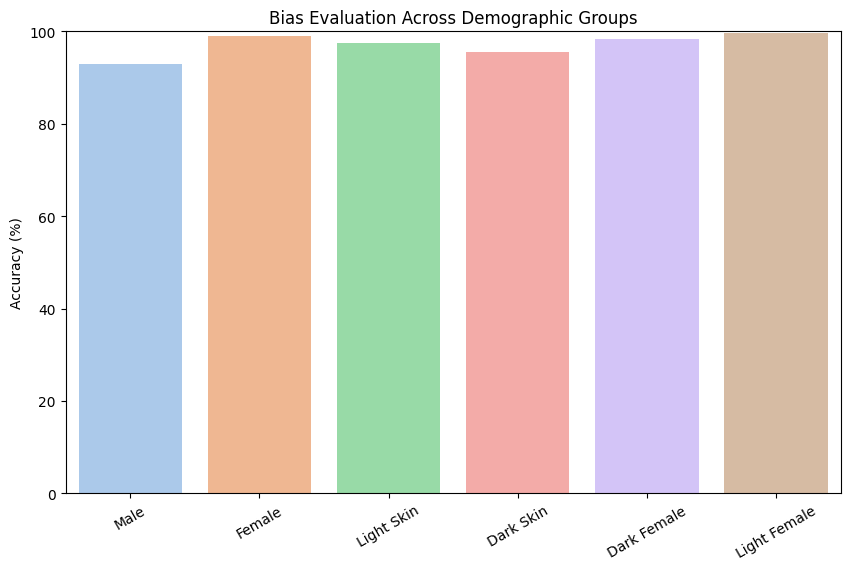

In [53]:
import seaborn as sns

group_acc = {
    "Male": male_acc * 100,
    "Female": female_acc * 100,
    "Light Skin": light_acc * 100,
    "Dark Skin": dark_acc * 100,
    "Dark Female": dark_female_acc * 100,
    "Light Female": light_female_acc * 100,
}

plt.figure(figsize=(10,6))
sns.barplot(x=list(group_acc.keys()), y=list(group_acc.values()), palette='pastel')
plt.ylabel("Accuracy (%)")
plt.title("Bias Evaluation Across Demographic Groups")
plt.ylim(0, 100)
plt.xticks(rotation=30)
plt.show()
